In [ ]:
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset , DataLoader
import matplotlib.pyplot as plt


def binary_mask(img_path : str)-> np.ndarray:

    try:
        img = Image.open(img_path).convert('RGB')
        img_arry = np.array(img)
    except FileNotFoundError:
        print("Error Not found")
        return None

    
    height ,width,_ = img_arry.shape

    mask = np.zeros((height,width), dtype = np.int64)

    unique_colors = np.unique(img_arry.reshape(-1, 3), axis=0)
    print("Unique RGB colors found in the image:")
    print(unique_colors)

    purple_color = np.array([106,13,173])

    belgium_pixels = np.all(img_arry == purple_color , axis=-1)

    mask[belgium_pixels] = 1

    return mask

class BorderDataset(Dataset):

    def __init__(self , image_path : str):
        
        self.mask = binary_mask(img_path=image_path)
        if self.mask is None:
            raise RuntimeError("mask Not created")
        
        self.height , self.width  = self.mask.shape

        self.pixel_data = []
        for y in range (self.height):
            for x in range(self.width):
                label = self.mask[y,x]
                self.pixel_data.append(((x,y), label))


    def __len__(self) -> int:

        return self.width * self.height
    

    def __getitem__(self , idx : int) -> tuple[torch.Tensor , torch.Tensor]:

        (x_cord , y_cord) , label = self.pixel_data[idx]

        x_norm = x_cord / (self.width-1)
        y_norm = y_cord / (self.height - 1)

        coordinates = torch.tensor([x_norm , y_norm] , dtype= torch.float32)

        label = torch.tensor(label , dtype=torch.long)

        return coordinates , label


# Ques 1 Belgium Netherlands Border

### 1.1 Image Processing and Dataset Creation 

#### Binary Mask

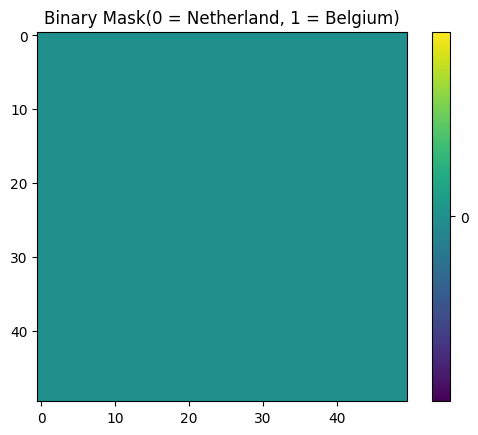

In [19]:
Imagepath = "border.png"

Binary_mask = binary_mask(img_path= Imagepath)

plt.imshow(Binary_mask , cmap="viridis")
plt.title(('Binary Mask(0 = Netherland, 1 = Belgium)'))
plt.colorbar(ticks = [0,1])
plt.show()